In [13]:
%matplotlib inline

In [58]:
# Upgrading Pandas for better rolling window support
!pip install icalendar
!pip install -I pandas==0.18.1

You are using pip version 8.1.1, however version 8.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached pytz-2016.4-py2.py3-none-any.whl
  Using cached numpy-1.11.0-cp35-cp35m-manylinux1_x86_64.whl
  Using cached python_dateutil-2.5.3-py2.py3-none-any.whl
  Using cached six-1.10.0-py2.py3-none-any.whl
You are using pip version 8.1.1, however version 8.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [15]:
import datetime
import pandas as pd
import numpy as np
import matplotlib as mpl

mpl.rcParams['savefig.dpi'] = 1.5 * mpl.rcParams['savefig.dpi']
mpl.style.use('ggplot')

pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 400)

# CONFIG
MY_EMAIL_ADDRESS = "phartig@twitter.com"
INPUT_FILE = 'phartig@twitter.com.ics'

In [7]:
from icalendar import Calendar, Event, vCalAddress

with open(INPUT_FILE, 'r') as fp:
    cal = Calendar.from_ical(fp.read())

In [8]:
is_confirmed = lambda c: c.get('STATUS') == 'CONFIRMED'
is_allday = lambda c: c.get('dtend') is None
is_event_type = lambda c, t: c.name == t

def is_accepted(component):
    attendees = component.get('attendee')
    attendees = attendees if type(attendees) == list else [attendees]
    me = list(filter(lambda x: x == vCalAddress('mailto:' + MY_EMAIL_ADDRESS), attendees))
    
    if not me:
        return False
    else:
        return me[0].params['PARTSTAT'] == 'ACCEPTED'
        
total = datetime.timedelta(seconds=0)
meetings = []

for component in cal.walk():
    if all([is_event_type(component, "VEVENT"),
            is_confirmed(component),
            not is_allday(component),
            is_accepted(component)]):
        time = component.get('dtend').dt - component.get('dtstart').dt
        meetings.append([component.get('summary'), component.get('dtstart').dt, component.get('dtend').dt])
            
m = pd.DataFrame(meetings, columns=['summary', 'start', 'end'])

In [ ]:
m['duration'] = m['end'] - m['start']
m.head()

In [ ]:
m_ = m[m['duration'] < datetime.timedelta(hours=8)]
total = m_['duration']

print("Time analyzed:", m.iloc[-1]['end'] - m.iloc[0]['start'])
print("Business days analyzed:", np.busday_count(m.iloc[0]['start'].date(), m.iloc[-1]['end'].date()))
print("Total # of meetings:", total.count())
print("Total time in meetings:", m_['duration'].sum())

In [ ]:
m_.sort_values('duration', ascending=False)

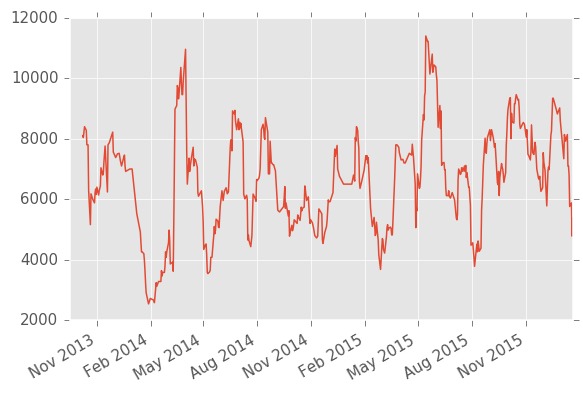

In [16]:
m2 = m_.copy()
m2.set_index('start', inplace=True)
m2 = m2.sort_index().truncate(before=m.iloc[0]['start'], after=m.iloc[-1]['end'])
win = m2['duration']\
    .map(lambda x: x.total_seconds() / 60 * 60)\
    .groupby(pd.TimeGrouper('D'))\
    .transform(np.sum)\
    .resample('D')\
    .mean()\
    .dropna()\
    .rolling(window=15)\
    .mean()\
    .plot()

In [ ]:
m2.tail()